In [1]:
import sys
sys.path.append("../")
from MLTK.accelerated_mri.utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom

data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\100099070170\308.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

kspace = transform_image_to_kspace(image)

In [2]:
# reduced_scan_percentage = sampling truncation --> Gibbs ringing
def reduced_scan_percentage(kspace):
    """Deletes a percentage of lines from the kspace
    
    Deletes an equal number of lines from the top and bottom of kspace
    to only keep the specified percentage of sampled lines. For example if
    the image has 256 lines and percentage is 50.0 then 64 lines will be
    deleted from the top and bottom and 128 will be kept in the middle.
    
    :param kspace: complex kspace data
    """
    
    percentage = random.randint(50, 100)
    if percentage < 100:
        percentage_delete = 1 - percentage / 100
        lines_to_delete = round(percentage_delete * kspace.shape[0] / 2)
        if lines_to_delete:
            approach = random.choice(["horizontal", "vertical"])
            if (approach == "horizontal"):
                kspace[0:lines_to_delete, :] = 0
                kspace[-lines_to_delete:, :] = 0
            elif (approach == "vertical"):
                kspace[:, 0:lines_to_delete] = 0
                kspace[:, -lines_to_delete:] = 0
    return kspace

In [3]:
# undersample --> foldover/phase wrap-around artefacts
# rectangular field of view (RFOV) won't be used, since this compressed the kspace
# output needs to remain the same to train the KIKI model
def undersample(kspace):
    """ Skipping every nth kspace line
    
    Simulates acquiring every nth (where n is the acceleration factor) line
    of kspace, starting from the midline. Commonly used in SENSE algorithm.
    
    :param kspace: complex k-space numpy.ndarray
    """
    
    #factor = random.randint(1, 16)
    factor = 2
    if factor > 1:
        mask = np.ones(kspace.shape, dtype=bool)
        midline = kspace.shape[0] // 2
        approach = random.choice(["horizontal", "vertical"])
        if (approach == "horizontal"):
            mask[midline::factor, :] = 0
            mask[midline::-factor, :] = 0
        elif (approach == "vertical"):
            mask[:, midline::factor] = 0
            mask[:, midline::-factor] = 0
        kspace[mask] = 0
        
    return kspace

#TODO: replace with method that keeps the middle lines
#TODO: add various filling methods

In [4]:
# partial_fourier
def partial_fourier(kspace):
    """ Partial Fourier
    
    Also known as half scan - only acquire a little over half of k-space
    or more and use conjugate symmetry to fill the rest.
    
    :param kspace: complex k-space
    """
    
    percentage = random.randint(50, 100)
    zf = random.choice([True, False])
    flip = random.choice([True, False])
    approach = random.choice(["horizontal", "vertical"])
    if percentage != 100:
        percentage = 1 - percentage / 100
        rows_to_skip = round(percentage * (kspace.shape[0] / 2 - 1))
        if rows_to_skip and zf: # lines not acquired are filled with zeros
            kspace[-rows_to_skip:] = 0
        elif rows_to_skip:
            kspace[-rows_to_skip:] = \
                np.roll(kspace[::-1, ::-1], shift=(1, 1), axis=(0, 1))[-rows_to_skip:]            
            np.conj(kspace[-rows_to_skip:], kspace[-rows_to_skip:]) # Conjugate replaced lines
    return kspace

# TODO: add horizontal/vertical approach, and flip

In [5]:
# still inside function
#kspace_reduced_scan_percentage = reduced_scan_percentage(kspace)
#kspace_undersample = undersample(kspace)
kspace_partial_fourier = partial_fourier(kspace)

img = transform_kspace_to_image(kspace_partial_fourier)
img = (img - np.mean(img)) / np.std(img)

(-0.5, 319.5, 319.5, -0.5)

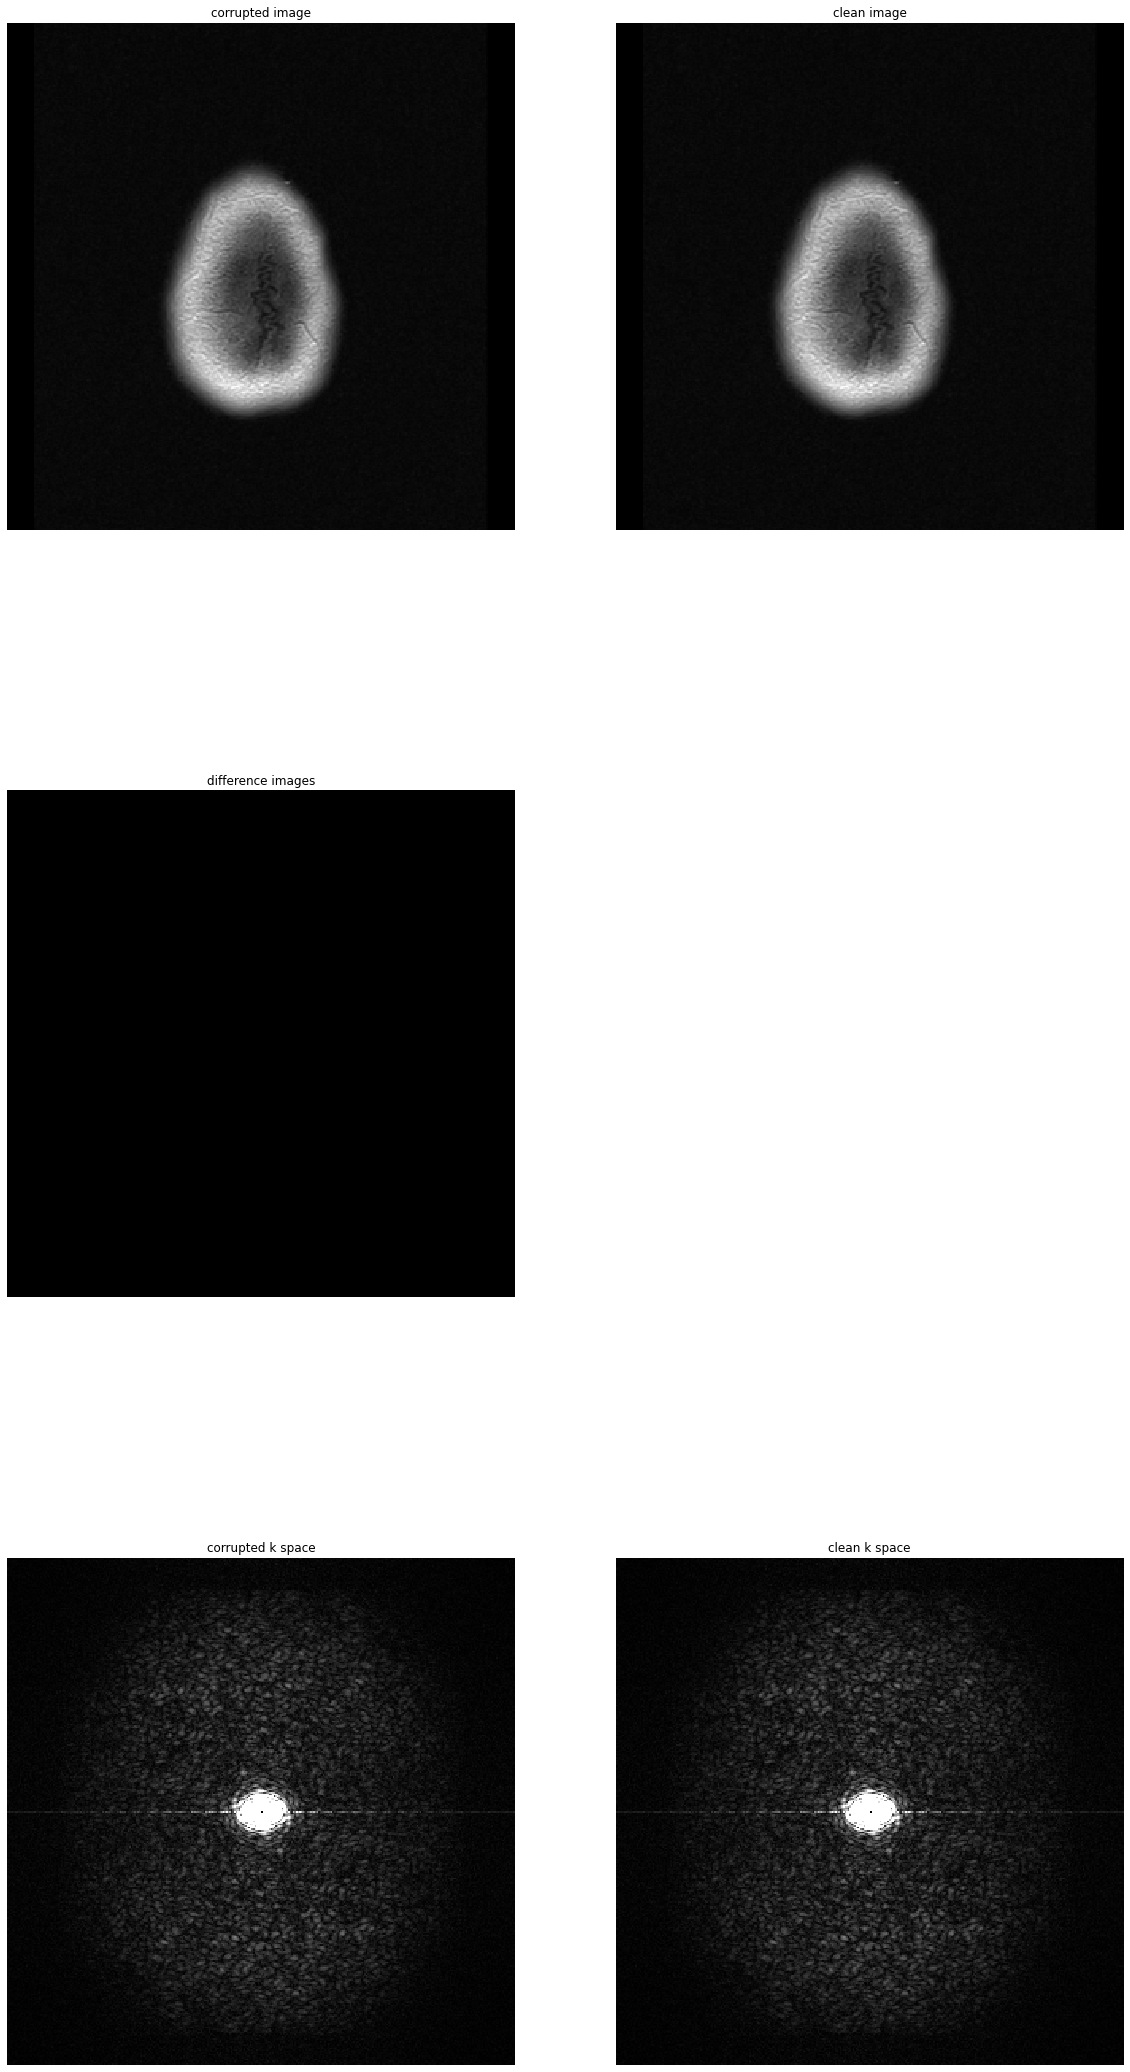

In [6]:
# plotting
hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')